# Goal: 
## Generating a test 3 Gaussian image centered at the 'same' maximum point of the real data. Then use the fit function to fit that data.
### The advantage is we would know in advance the parameters of the 3 Gaussians to be used as a guess in the fitting process.

In [2]:
%matplotlib inline
from foxsi_optics_calib.psf import psf2d
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import astropy.units as u
from foxsi_optics_calib.psf import PSF2DModel
from astropy.modeling.fitting import LevMarLSQFitter

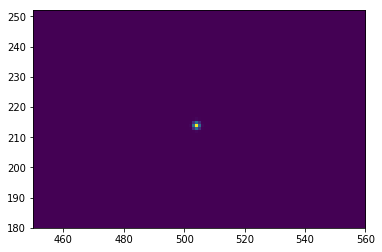

In [67]:
angle = (0 * u.deg).to('rad').value
amplitude = 43717
#psf = psf2d(amplitude1=amplitude*0.7, x_stddev1=0.7, y_stddev1=0.7,
#                       amplitude2=amplitude*0.3, x_stddev2=2, y_stddev2=1.2,
#                       amplitude3=amplitude*0.05, x_stddev3=4, y_stddev3=5,
#                       x_mean=504, y_mean=214, theta=angle, offset=0.1)

psf = Gaussian2D(amplitude=amplitude*0.7, x_stddev=0.7, y_stddev=0.7,x_mean=504, y_mean=214, theta=angle)

x, y = np.meshgrid(*[np.arange(v) for v in (1024, 1024)])
simdata = psf(x, y)

plt.imshow(simdata, origin='lower', cmap=plt.cm.viridis)
plt.ylim(180,252)
plt.xlim(450,560)
plt.show()

Reading data:

In [66]:
import astropy.units as u
from foxsi_optics_calib.ccd.ccd import AndorCCDPsfFitImage, AndorCCDPsfImage

focal_length = 2 * u.m

f = '/Volumes/Storage/FOXSI/OpCal/X10Test/data/kFOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_0mmZ.fits'
d = '/Volumes/Storage/FOXSI/OpCal/X10Test/Dark1_FOXSI3_X10-Test_CCD_T2Sx6_10kV_0p02mA_+15mmZ.fits'

psf_img = AndorCCDPsfImage(f, d, focal_length) #for read data
#psffit_img = AndorCCDPsfFitImage(f, d, focal_length) #for read and fit data

Found 6 exposures. Averaging...


Which's the size of the arrays?

In [16]:
print('Real Data size = ',psf_img.xaxis.shape,'Simulated Data size = ',simdata.shape)

Real Data size =  (1024, 1024) Simulated Data size =  (1024, 1024)


Plotting **simulated** vs **real** data:

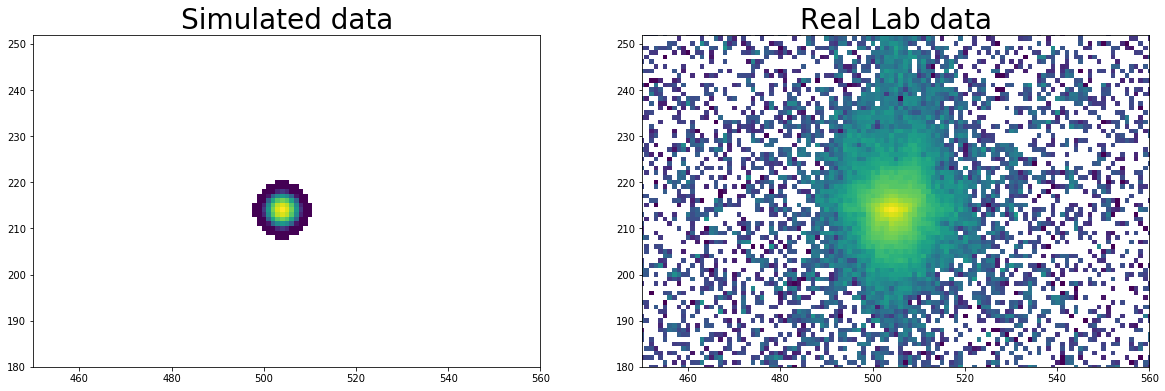

In [68]:
fig = plt.figure(figsize=[20,30])
plt.subplot(1, 2, 1)
plt.imshow(simdata, origin='lower', vmin=1e-4, cmap=plt.cm.viridis, norm=LogNorm())
plt.title('Simulated data',fontsize=28)
plt.ylim(180,252)
plt.xlim(450,560)
plt.subplot(1, 2, 2)
plt.imshow(psf_img.data, origin='lower', cmap=plt.cm.viridis, norm=LogNorm())
plt.title('Real Lab data',fontsize=28)
plt.ylim(180,252)
plt.xlim(450,560)
plt.show()

Creates guess using same values used for making simulated data:

In [72]:
#g_init = PSF2DModel(amplitude1=amplitude*0.7, x_stddev1=0.7, y_stddev1=0.7,
#                       amplitude2=amplitude*0.3, x_stddev2=2, y_stddev2=1.2,
#                       amplitude3=amplitude*0.05, x_stddev3=4, y_stddev3=5,
#                       x_mean=504, y_mean=210, theta=angle, offset=0.1)

g_init = Gaussian2D(amplitude=amplitude*0.7, x_stddev=0.7, y_stddev=0.7,
                       x_mean=504, y_mean=210, theta=angle)

fit = LevMarLSQFitter()

Trying to fit using *arcsec* coordinates from the original real data:

In [73]:
fitted_model = fit(g_init, psf_img.xaxis.to('arcsec').value,
                           psf_img.yaxis.to('arcsec').value, simdata, maxiter=200)

Since it did not work, what if we now try to fit the gaussians but using the X and Y coordinates? 

In [74]:
fitted_model = fit(g_init, x, y, simdata, maxiter=200,acc=1e-03, epsilon=1.4901161193847656e-08)

### It still does not work, but why?

In [78]:
print(fit.fit_info['message'])


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.001000


In [84]:
output = fitted_model(x, y)

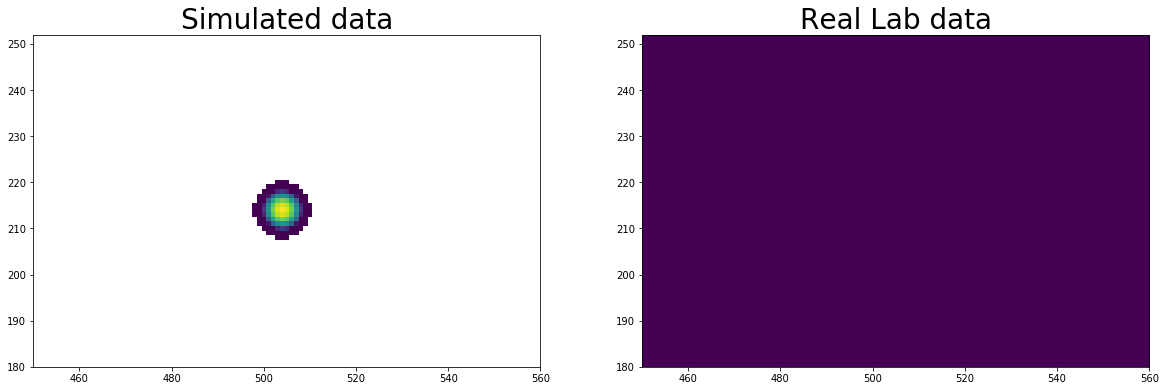

In [87]:
fig = plt.figure(figsize=[20,30])
plt.subplot(1, 2, 1)
plt.imshow(simdata, origin='lower', vmin=1e-4, cmap=plt.cm.viridis, norm=LogNorm())
plt.title('Simulated data',fontsize=28)
plt.ylim(180,252)
plt.xlim(450,560)
plt.subplot(1, 2, 2)
plt.imshow(output, origin='lower', cmap=plt.cm.viridis)
plt.title('Real Lab data',fontsize=28)
plt.ylim(180,252)
plt.xlim(450,560)
plt.show()

In [88]:
fitted_model

<Gaussian2D(amplitude=-19.108662920943175, x_mean=504.0, y_mean=209.1451649876224, x_stddev=0.6999999350148673, y_stddev=1.1754943508222875e-38, theta=2.2400288644713352e-14)>

In [46]:
print('x_stddev1 = ',fitted_model.x_stddev1)
print('x_stddev2 = ',fitted_model.x_stddev2)
print('x_stddev3 = ',fitted_model.x_stddev3)
print('y_stddev1 = ',fitted_model.y_stddev1)
print('y_stddev2 = ',fitted_model.y_stddev2)
print('y_stddev3 = ',fitted_model.y_stddev3)

x_stddev1 =  Parameter('x_stddev1', value=0.7, bounds=(0, None))
x_stddev2 =  Parameter('x_stddev2', value=2.0, bounds=(0, None))
x_stddev3 =  Parameter('x_stddev3', value=4.0, bounds=(0, None))
y_stddev1 =  Parameter('y_stddev1', value=0.7, bounds=(0, None))
y_stddev2 =  Parameter('y_stddev2', value=1.2, bounds=(0, None))
y_stddev3 =  Parameter('y_stddev3', value=5.0, bounds=(0, None))


In [47]:
fitted_model

<PSF2DModel(amplitude1=30601.899999999998, amplitude2=13115.1, amplitude3=2185.85, x_stddev1=0.7, x_stddev2=2.0, x_stddev3=4.0, y_stddev1=0.7, y_stddev2=1.2, y_stddev3=5.0, x_mean=504.0, y_mean=210.0, theta=0.0, offset=0.1)>

In [50]:
from astropy.modeling.functional_models import Gaussian2D

In [54]:
g = Gaussian2D(amplitude=1, x_mean=0, y_mean=0, x_stddev=None, y_stddev=None, theta=None, cov_matrix=None)

In [59]:
g = Gaussian2D(amplitude=amplitude*0.7, x_stddev=0.7, y_stddev=0.7)

In [61]:
g?

In [48]:
fit.fit_info

{'cov_x': array([[  5.05498216e+01,   1.10362618e+01,   1.87960781e+00,
          -9.66890546e-02,   1.09097881e-01,  -3.34740213e-02,
           9.74125002e-02,   4.11527209e-02,  -3.47111476e-02,
          -2.26800133e-04,  -7.09472619e-03,   2.25138497e-08,
          -5.05550173e+01],
        [  1.10362618e+01,   3.29114965e+00,   4.10403116e-01,
          -4.04841001e-02,   4.57023903e-02,  -1.40545280e-02,
           4.07657230e-02,   1.72573466e-02,  -1.43982923e-02,
          -1.05158271e-03,  -1.54884674e-03,   4.69625945e-09,
          -1.10384407e+01],
        [  1.87960781e+00,   4.10403116e-01,   6.99090573e-02,
          -3.59519245e-03,   4.05657315e-03,  -1.24460131e-03,
           3.62209175e-03,   1.53017718e-03,  -1.29082019e-03,
          -8.43789447e-06,  -2.68972882e-04,   8.34983577e-10,
          -1.87980101e+00],
        [ -9.66890546e-02,  -4.04841001e-02,  -3.59519245e-03,
           3.19391138e+01,  -2.32117995e+01,   1.85260039e+01,
          -3.14961768e+01

In [34]:
?fit

In [ ]:
acc=1e-07, epsilon=1.4901161193847656e-08